# An implicit linear shallow water model

What am I going to show: hybridisation and preconditioning. Equation comes from "somewhere", but we just need a setup.

The non-linear rotating shallow water system is a fundamental equation set in geophysical fluid dynamics. A complete non-linear method will often require a sequence of solutions to a linearized model (Newton-type methods). Therefore, in this notebook we will look at solvers for the linear shallow water model on the sphere:

$$
\frac{\partial \mathbf{u}}{\partial t} + f\mathbf{u}^{\perp} + g\nabla D = 0, \\
\frac{\partial D}{\partial t} + H\nabla \cdot \mathbf{u} = 0.
$$

This defines a coupled set of equations for a velocity $\mathbf{u}$ and depth $D$. Here, $f$ is the Coriolis parameter, $g$ is the acceleration due to gravity, and $H$ is a mean layer depth. Our equations are defined on a two-dimensional sphere embedded in $\mathbb{R}^3$, $\Omega$.

## Spatial discretization

Now we discretize in space. First, we mulitply the first equation by a test function $\mathbf{w} \in V \subset H(\text{div}; \Omega)$, and the second equation by a test function $\phi \in U \subset L^2(\Omega)$. Integrating both equations by parts, we obtain the following semi-discrete problem: find $\mathbf{u}(x, t), D(x, t) \in V \times U$ such that:

$$
\int_\Omega \mathbf{w}\cdot\left(\frac{\partial\mathbf{u}}{\partial t} + f\mathbf{u}^{\perp}\right)\, \mathrm{d}x - g\int_\Omega D\nabla\cdot\mathbf{w}\, \mathrm{d}x = 0, \quad \forall \mathbf{w} \in V,\\
\int_\Omega \phi \frac{\partial D}{\partial t}\,\mathrm{d}x + H\int_\Omega \phi \nabla\cdot\mathbf{u}\,\mathrm{d}x = 0, \quad \forall \phi \in U.
$$

## Time discretization (implicit midpoint rule)

Simplify notation in this fully discrete problem, drop above intro (can say "comes from GFD"). Need to note what the spaces are.

We now need to discretize in time. Using the implicit midpoint method, solving the time-dependent problem requires successive solutions to the spatial discretization at time $t_{n+1} = t_{n} + \Delta t$ for $u^{n+1}, D^{n+1} \in V \times U$ satifying

$$
\int_\Omega \mathbf{w}\cdot\mathbf{u}^{n+1}\,\mathrm{d}x + \frac{\Delta t}{2}\int_\Omega \mathbf{w}\cdot f\mathbf{u}^{n+1}\,\mathrm{d}x - \frac{g\Delta t}{2}\int_\Omega D^{n+1}\nabla\cdot\mathbf{w}\,\mathrm{d}x = -R^n\lbrack \mathbf{w} \rbrack, \quad \forall \mathbf{w} \in V, \\
\int_\Omega \phi D^{n+1}\,\mathrm{d}x + \frac{H\Delta t}{2}\int_\Omega \phi\nabla\cdot\mathbf{u}^{n+1}\,\mathrm{d}x = -R^n\lbrack \phi \rbrack, \quad \forall \phi \in V,
$$

where the residual co-vectors are defined as:

$$
R^n\lbrack \mathbf{w} \rbrack = \int_\Omega \mathbf{w}\cdot\mathbf{u}^{n}\,\mathrm{d}x - \frac{\Delta t}{2}\int_\Omega \mathbf{w}\cdot f\mathbf{u}^{n}\,\mathrm{d}x + \frac{g\Delta t}{2}\int_\Omega D^{n}\nabla\cdot\mathbf{w}\,\mathrm{d}x \\
R^n\lbrack \phi \rbrack = \int_\Omega \phi D^{n}\,\mathrm{d}x - \frac{H\Delta t}{2}\int_\Omega \phi\nabla\cdot\mathbf{u}^{n}\,\mathrm{d}x.
$$

For each time-step, we require the numerical solution to the saddle-point system:

$$
\mathbf{A}\mathbf{x} \equiv \begin{bmatrix} A & -\frac{g\Delta t}{2}B^T \\ \frac{H\Delta t}{2} B & C \end{bmatrix} \begin{Bmatrix} U^{n+1} \\ D^{n+1}\end{Bmatrix} = \begin{Bmatrix} -R^n\lbrack \mathbf{w} \rbrack \\ -R^n\lbrack \phi \rbrack \end{Bmatrix} \equiv \mathbf{b}
$$

for the coefficent vectors $U^{n+1}$ and $D^{n+1}$. One standard approach for such systems revolves around preconditioning the operator $\mathbf{A}$ by an approximate inverse of the its Schur-complement factorization. In this notebook, we will highlight a techniqued known as "hybridization," whereby a different discretization (approximating the same system) replaces the original $H(\text{div})\times L^2$ mixed method by a "hybrid" version. This new discretization permits the use of element-wise static condensation to exactly eliminate the prognostic unknowns for a reduced problem on mesh interfaces.

## Implementation

To solve the problem in a concrete setting, we need two things.  A domain, and initial conditions for $\mathbf{u}$ and $D$. Our domain will be a spherical mesh consisting of simplices and a cubic coordinate field. This way, we can have a suitable approximation of the curvature.

We begin by importing Firedrake and defining some relevant constants.

In [1]:
%matplotlib notebook
from firedrake import *

R0 = 6371220.0
R = Constant(R0)              # Radius of the earth [m]
H = Constant(5960.0)          # Mean depth [m]
day = 24. * 60. * 60.         # Seconds in a day [s]
Omega_f = Constant(7.292E-5)  # Angular rotation rate [rads]
g = Constant(9.80616)         # Acceleration due to gravity [m/s^2]
mesh_degree = 3               # Cubic coordinate field
refinements = 3               # Number of icosahedron refinements
mesh = IcosahedralSphereMesh(R0, refinements,
                             degree=mesh_degree)

Now we initialize and orient the coordinates on the sphere:

In [2]:
x = SpatialCoordinate(mesh)
global_normal = as_vector([x[0], x[1], x[2]])
mesh.init_cell_orientations(global_normal)

Let's look at it

<IPython.core.display.Javascript object>


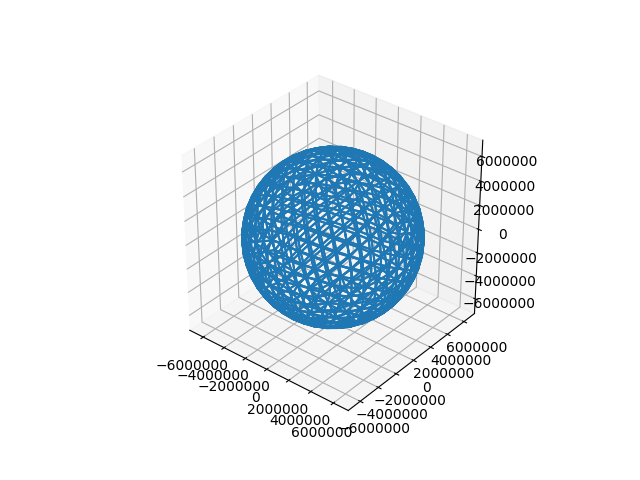

In [3]:
plot(mesh);

We now define the mixed method method by choosing our discrete function spaces. We use a BDM mixed method, taking $V = BDM_2$ and $U = DG_1$:

In [5]:
V = FunctionSpace(mesh, "BDM", 2)
U = FunctionSpace(mesh, "DG", 1)
W = V * U

Now we add the Coriolis term as a function in a continuous finite element space:

In [8]:
f = 2 * Omega_f * x[2] / R

These parameters want simplified following the rewrite above.

For our initial conditions, we choose profiles for $\mathbf{u}$ and $D$ such that they are in a state of geostrophic balance:

$$
\mathbf{u}(\mathbf{x}, 0) = \frac{u_{\text{max}}}{R_{\odot}}\left( -y, x, 0\right), \\
D(\mathbf{x}, 0) = H - \left(R_\odot\Omega_f u_{\text{max}} + \frac{u_{\text{max}}^2}{2}\right)\frac{z^2}{gR^2_\odot}
$$

where $u_{\text{max}} = 2\pi R_\odot/(12 \text{days}) \approx 38.6 \text{m}\text{s}^{-1}$. Since there is no forcing or topography, the solution should remain steady throughout the entire simulation. In Firedrake, we simply define the expressions in UFL and project/interpolate into the relevant finite element spaces:

In [9]:
u_0 = 2*pi*R0/(12*day)
u_max = Constant(u_0)                 # Maximum amplitude of the zonal wind [m/s]
u_expr = as_vector([-u_max*x[1]/R, u_max*x[0]/R, 0.0])
D_expr = H - ((R * Omega_f * u_max + u_max*u_max/2.0)*(x[2]*x[2]/(R*R)))/g
u0 = Function(V).project(u_expr)
D0 = Function(U).interpolate(D_expr)

We also need solution functions for $\mathbf{u}^{n+1}$ and $\mathbf{u}^n$ (as well as $D^{n+1}$ and $D^n$). Additionally, we assign the fields with their initial values.

In [10]:
wn = Function(W, name="w^n")          # Fields at time-step n
un, Dn = wn.split()                   # Split mixed function for individual fields
un.assign(u0)
Dn.assign(D0)
wn1 = Function(W, name="w^{n+1}")     # Fields at time-tep n+1
un1, Dn1 = wn1.split()

Now we set the maximum simulation time, time-step size, time-stepping coefficients, and the relevant test/trial functions:

In [11]:
tmax = day
Dt = 4000.0
dt = Constant(Dt)                     # Time-step size [s]
alpha = Constant(0.5)                 # Midpoint method
u, D = TrialFunctions(W)
w, phi = TestFunctions(W)

Finally, we define the "perp" operator:
Write maths for perp, slow down and explain that it's just python so functions

In [12]:
outward_normal = CellNormal(mesh)
perp = lambda u: cross(outward_normal, u)

Now that we have initalized our fields defined relevant parameters, we define our finite element problem in residual form:

In [13]:
# Want to get here fast.
uD_eqn = (inner(w, u) + alpha*dt*inner(w, f*perp(u))
          - alpha*dt*g*div(w)*D
          - inner(w, un)
          + alpha*dt*inner(w, f*perp(un))
          - alpha*dt*g*div(w)*Dn
          + phi*D + alpha*dt*H*phi*div(u)
          - phi*Dn + alpha*dt*H*phi*div(un))*dx

And our problem/solver context with a Schur-complement preconditioner:

In [31]:
uD_problem = LinearVariationalProblem(lhs(uD_eqn), rhs(uD_eqn), wn1)
solver_parameters = {'ksp_type': 'gmres',
                     'ksp_rtol': 1.0e-8,
                     'pc_type': 'fieldsplit',
                     'pc_fieldsplit_type': 'schur',
                     'pc_fieldsplit_schur_fact_type': 'full',
                     # Algebraic manipulations to approximate schur complement
                     'pc_fieldsplit_schur_precondition': 'selfp',
                     'fieldsplit_0': {'ksp_type': 'preonly',
                                      'pc_type': 'bjacobi',
                                      'sub_pc_type': 'ilu'},
                     'fieldsplit_1': {'ksp_type': 'preonly',
                                      'pc_type': 'gamg',
                                      'mg_levels': {'ksp_type': 'chebyshev',
                                                    'ksp_max_it': 2,
                                                    'pc_type': 'bjacobi',
                                                    'sub_pc_type': 'ilu'}}}
uD_solver = LinearVariationalSolver(uD_problem,
                                    solver_parameters=solver_parameters)

Now we simply execute the time loop:

In [15]:
t = 0.0
while t < tmax:        # Start time loop
    t += Dt
    uD_solver.solve()  # Solve for updated fields
    un.assign(un1)     # Update fields for next time-step
    Dn.assign(Dn1)

Since the flow is steady, the relative error in the fields compared with their initial values should be small (relative to discretization error). We can do this using Firedrake's `errornorm` and `norm` functions:

In [16]:
Uerr = errornorm(u_expr, un1, norm_type="L2")/norm(u_expr, norm_type="L2")
Derr = errornorm(D_expr, Dn1, norm_type="L2")/norm(D_expr, norm_type="L2")
print("Error in the velocity: %s" % Uerr)
print("Error in the depth: %s" % Derr)

Error in the velocity: 0.01922826643067052
Error in the depth: 0.0024565602578863906


### Solver convergence

Although the code we wrote above works fine, let's take a closer look at the solver by turning on PETSc's KSP monitor. Resetting back to the initial state, we now turn on the monitor and run for a single time-step:

In [33]:
%%timeit
solver_parameters['ksp_monitor_true_residual'] = True
from firedrake.solving_utils import KSPReasons
un.assign(u0)
Dn.assign(D0)
wn1.assign(0.0)
Omega_f.assign(7e-5)
# this approach is not parameter robust
#
uD_solver = LinearVariationalSolver(uD_problem,
                                    solver_parameters=solver_parameters)
uD_solver.solve()
#print("gmres iterations = {}, converged reason = {}".format(
#       uD_solver.snes.ksp.getIterationNumber(), 
#       KSPReasons[uD_solver.snes.ksp.getConvergedReason()]))

99.6 ms ± 805 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


While this is not terrible, our preconditioner is inexact. And unless we want to build the entire mass matrix $A$, a diagonal approximation won't gather the contributions of the Coriolis terms. Our `fieldsplit` preconditioner can be modified to contain more aggressive options for the `fieldsplit_0` and `fieldsplit_1` configurations. This is at the cost of more expensive GMRES iterations.

## The hybridized mixed method

Replace with pictures from prize-winning talk slides.

Hybridizing the mixed formulation of the shallow water equations is an alternative approach which avoids building a (global) dense inverse, while maintaining an exact (up to rounding errors) factorization of the reformulated system. The classical hybridization of mixed methods is summarized as follow. With $\mathcal{E}$ denoting the set of edges/faces (facets) of $\Omega$, we seek approximations $\tilde{\mathbf{u}}, D, \lambda \in \tilde{V} \times U \times T$, where

$$
\tilde{V} = \lbrace \color{orange}{\mathbf{w}} \in \lbrack L^2(\Omega) \rbrack^n : \mathbf{w}|_K \in V(K), \, \forall K \in \Omega \rbrace \\
T = \texttt{Trace}(V) = \lbrace \gamma \in L^2(\mathcal{E}) : \gamma|_e \text{ and } \mathbf{w}\cdot\mathbf{n}|_e \in P_k(e), \, \forall e \in \mathcal{E} \text{ and } \forall \mathbf{w} \in V \rbrace.
$$

The space $\tilde{V}$ is a discontinuous variant of the $H(\text{div})$ space $V$. The space $T$ is the trace of $V$, consisting of polynomials only defined on the skeleton of the mesh. By construction, functions in $T$ lie in the same polynomial space as the normal components of vector functions in $V$. The approximations satisfy the variational problem:

$$
\int_\Omega \mathbf{w}\cdot\left(\frac{\partial\tilde{\mathbf{u}}}{\partial t} + f\tilde{\mathbf{u}}^{\perp}\right)\, \mathrm{d}x - g\int_\Omega D\nabla\cdot\mathbf{w}\, \mathrm{d}x +
\sum_{K \in \Omega} \int_{\partial K} \lambda \mathbf{w}\cdot\mathbf{n}\,\mathrm{d}s = 0, \quad \forall \mathbf{w} \in \tilde{V},\\
\int_\Omega \phi \frac{\partial D}{\partial t}\,\mathrm{d}x + H\int_\Omega \phi \nabla\cdot\tilde{\mathbf{u}}\,\mathrm{d}x = 0, \quad \forall \phi \in U, \\
\sum_{K \in \Omega} \int_{\partial K} \gamma\tilde{\mathbf{u}}\cdot\mathbf{n}\,\mathrm{d}s = 0, \quad \forall \gamma \in T.
$$

This is the "hybridized" mixed method, resulting in an augmented system with an additional unknown $\lambda$. It can be shown that $\lambda$ is a scaled approximation of $D$, as the surface terms appear due to the fact that $\tilde{\mathbf{u}}\cdot\mathbf{n}$ is no longer continuous between cell interfaces. The new velocity $\tilde{\mathbf{u}}$, albeit sought a priori in a discontinuous space, actually coincides with its $H(\text{div})$-conforming counterpart $\mathbf{u}$. This is due to the fact that functions in $T$ are acting a Lagrange multipliers in the third equation, enforcing continuity of $\tilde{\mathbf{u}}\cdot\mathbf{n}$ across facets.

### The discrete hybridized system

After proceeding in the usual finite element way, we obtain a matrix system of the form:

$$
\begin{bmatrix} \tilde{A} & -\frac{g\Delta t}{2}B^T & E^T\\ \frac{H\Delta t}{2} B & C & 0 \\ E & 0 & 0\end{bmatrix} \begin{Bmatrix} \tilde{U}^{n+1} \\ D^{n+1} \\ \Lambda \end{Bmatrix} = \begin{Bmatrix} -R^n\lbrack \mathbf{w} \rbrack \\ -R^n\lbrack \phi \rbrack \\ 0 \end{Bmatrix}.
$$

Upon initial inspection, it may appear that hybridizing the mixed problem is counter-productive; since our velocity is discontinuous, we have introduced many more degrees of freedom to determine for $\tilde{U}^{n+1}$ in addition to the unknowns for $\Lambda$. The advantage of hybridization is more clear after realizing that, since velocity and depth unknowns coupled within the cell interiors only (with the trace unknown determining inter-cell coupling), both $\tilde{U}^{n+1}$ and $D^{n+1}$ can be eliminated **locally**. Using element-wise static condensation, a reduced problem for $\Lambda$ can be formed:

$$
\begin{bmatrix} E & 0 \end{bmatrix}\begin{bmatrix} \tilde{A} & -\frac{g\Delta t}{2}B^T \\ \frac{H\Delta t}{2} B & C\end{bmatrix}^{-1}\begin{bmatrix} E^T \\ 0 \end{bmatrix}\Lambda = \begin{bmatrix} E & 0 \end{bmatrix}\begin{bmatrix} \tilde{A} & -\frac{g\Delta t}{2}B^T \\ \frac{H\Delta t}{2} B & C\end{bmatrix}^{-1}\begin{Bmatrix} -R^n\lbrack \mathbf{w} \rbrack \\ -R^n\lbrack \phi \rbrack\end{Bmatrix}.
$$

There are a number of advantages to inverting the $\Lambda$ system over the original mixed problem.
* The full hybridized system is **never** explicitly assembled, nor the sub-matrices (or the sub-blocks); only the cell-local contributions are assembled (and inverted) to produce the global $\Lambda$-system.

* Since $\Lambda$ is a scaled approximation of $D$, the resulting condensed operator is spectrally similar to the exact Schur-complement $C + gH\frac{\Delta t^2}{4}B A^{-1} B^T$ in the original formulation.

* Once $\Lambda$ is determined, $\tilde{U}^{n+1}$ and $D^{n+1}$ can be recovered **locally** by inverting the local problem:
$$
\begin{Bmatrix} \tilde{U}^{n+1} \\ D^{n+1}\end{Bmatrix} = \begin{bmatrix} \tilde{A} & -\frac{g\Delta t}{2}B^T \\ \frac{H\Delta t}{2} B & C\end{bmatrix}^{-1} \left(\begin{Bmatrix} -R^n\lbrack \mathbf{w} \rbrack \\ -R^n\lbrack \phi \rbrack\end{Bmatrix}  - \begin{bmatrix} E^T \\ 0 \end{bmatrix}\Lambda\right).
$$

## Firedrake's hybridization interface

People are often dissuaded from hybridized finite element solvers for their tedious implementation stages. However, Firedrake possesses an abstraction layer for dense linear algebra on finite element matrices and vectors (Slate). This enables Firedrake to automatically generate code for the local static condensation and recovery operations necessary for a fully-implemented hybridization method. Building off of Firedrake's `python` preconditioners, changing the code as above to use hybridization becomes a simple change in solver paramters.

Hybridization for problems of this type are automated as a Python preconditioner, which manipulates UFL representations of the mixed system and forms the corresponding hybrid formulation. One can use this preconditioner by simply invoking:

```python
'mat_type': 'matfree',
'pc_type': 'python',
'pc_python_type': 'firedrake.HybridizationPC',
```

As with all PETSc preconditioners, the `HybridizationPC` can be configured through standard PETSc options. For example, just run:

In [35]:
hybrid_solver_parameters = {'ksp_type': 'preonly',
                            'mat_type': 'matfree',
                            'pc_type': 'python',
                            'pc_python_type': 'firedrake.HybridizationPC',
                            # CG + AMG on the trace system
                            'hybridization': {'ksp_type': 'preonly',
                                              'pc_type': 'gamg',
                                              'ksp_rtol': 1e-8,
                                              'mg_levels': {'ksp_type': 'chebyshev',
                                                            'ksp_max_it': 2,
                                                            'pc_type': 'bjacobi',
                                                            'sub_pc_type': 'ilu'}}}

By default, all local inversions are performed via an LU factorization with partial pivoting (unless if the local matrices are small enough to use explicit formulae). The generated code utilizes Eigen for all dense linear algebra. The `'hybridization'` options prefix allows one to directly specify solver options for the trace system.

We remark here that since the hybridized solution for the velocity is in a discontinuous space, the result must be transfered back into the original $H(\text{div})$-conforming finite element space. The preconditioner automatically projects the locally computed velocity back into the $H(\text{div})$ space via local facet averaging.

Now one can run the simulation just as before:

In [ ]:
un.assign(u0)
Dn.assign(D0)
wn1.assign(0.0)
uD_solver = LinearVariationalSolver(uD_problem,
                                    solver_parameters=hybrid_solver_parameters)

t = 0.0
while t < tmax:        # Start time loop
    t += Dt
    uD_solver.solve()  # Solve for updated fields
    un.assign(un1)     # Update fields for next time-step
    Dn.assign(Dn1)

Uerr = errornorm(u_expr, un1, norm_type="L2")/norm(u_expr, norm_type="L2")
Derr = errornorm(D_expr, Dn1, norm_type="L2")/norm(D_expr, norm_type="L2")
print("Error in the velocity: %s" % Uerr)
print("Error in the depth: %s" % Derr)

Hybridization becomes far more advantageous for large, parallel simuations due to its natural parallelism. The performance benefits of static condensation become especially apparent when increasing the approximation degree.

### Relationship between inner tolerance and outer convergence

One may wonder if the hybridization preconditioner is *actually* solving the same problem. To confirm this, let us modify the solver options:

In [24]:
hybrid_solver_parameters['ksp_type'] = 'gmres'
hybrid_solver_parameters['ksp_monitor_true_residual'] = True
hybrid_solver_parameters['hybridization']['ksp_monitor_true_residual'] = True

With `gmres` iterating on the outer system, the residual of the original mixed system will be checked to ensure outer convergence. We may also inspect how the outer and inner (trace) solvers converge by turning on the KSP monitors.

In [36]:
%%timeit
un.assign(u0)
Dn.assign(D0)
wn1.assign(0.0)
# Does this DTRT?
# Omega_f.assign(1e-2)
uD_solver = LinearVariationalSolver(uD_problem,
                                    solver_parameters=hybrid_solver_parameters)
uD_solver.solve()
#print("gmres iterations = {}, converged reason = {}".format(
#       uD_solver.snes.ksp.getIterationNumber(), 
#       KSPReasons[uD_solver.snes.ksp.getConvergedReason()]))

147 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


And now parameterizing this based on the relative tolerance of the solver:

In [ ]:
# NBVAL_SKIP
for rtol in (1.0e-4, 1.0e-5, 1.0e-6, 1.0e-7):
    hrtol = rtol*0.1
    hybrid_solver_parameters['ksp_rtol'] = rtol
    hybrid_solver_parameters['hybridization']['ksp_rtol'] = hrtol
    un.assign(u0)
    Dn.assign(D0)
    wn1.assign(0.0)
    uD_solver = LinearVariationalSolver(uD_problem,
                                        solver_parameters=hybrid_solver_parameters)
    uD_solver.solve()
    print("gmres rtol = {}\ntrace rtol = {}\ngmres iterations = {}, converged reason = {}".format(
           rtol, hrtol, uD_solver.snes.ksp.getIterationNumber(),
           KSPReasons[uD_solver.snes.ksp.getConvergedReason()]))